In [62]:
from matplotlib import pyplot as plt

In [63]:
import os
from tqdm import tqdm
import pathlib
import numpy as np
import pandas as pd
import pickle
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import MinMaxScaler

import torch as t

from datetime import datetime as dt

DEVICE = "cuda" if t.cuda.is_available() else 'cpu'

tqdm.pandas()
pd.set_option('display.max_columns', None)

In [64]:
DATA_DIR = pathlib.Path("./data/")
RS = 3984765

In [65]:
train_df = pd.read_parquet(DATA_DIR.joinpath("train.parquet"))
print(train_df.shape)
index_split = int(train_df.shape[0] * 0.8)
test_df = train_df[index_split:]
train_df = train_df[:index_split]
test_df.shape

(153417, 27)


(30684, 27)

In [66]:
train_df["feature0"].quantile(0.99)

63.37731798107359

In [67]:
t.rand(2)

tensor([0.8543, 0.0707])

In [68]:


class Pipe:
    def __init__(self, cols_to_short, batch_size=64, noise_str=0.01):
        self.min_max = MinMaxScaler()
        self.cols_to_short = cols_to_short
        self.batch_size = batch_size
        self.noise_str = noise_str


    def fit(self, X: pd.DataFrame):
        X_ = self.quntize(X)
        X_["feature4"] = (X_["feature4"] == "gas1") * 1
        self.min_max.fit(X_)

    def quntize(self, X):
        X_ = X.copy()
        
        # for col in self.cols_to_short:
        #     X_ = X_[X_[col] < X_[col].quantile(0.999)]
        
        return X_

    def transform(self, X, y=None, train_df=False):
        X_ = X.copy()
        if y is not None:
            y_ = y.copy()


        if train_df:
            X_ = self.quntize(X_)
        if train_df and y is not None:
            y_ = y_.iloc[X_.index]
        

        X_["feature4"] = (X_["feature4"] == "gas1") * 1
        

        X_ = pd.DataFrame(self.min_max.transform(X_), columns=X_.columns) 
        X_["feature_23_cat"] = (X_["feature23"] > 70) * 1
        X_["feature_24_cat"] = (X_["feature24"] > 20) * 1
        X_["feature_17_cat"] = (X_["feature17"] > -10) * 1
        X_["feature_1_cat"] = (X_["feature1"] > 25) * 1
        
        X_["cluster"] = (X_["feature4"] == 1) * 1
        X_.drop("feature4", axis=1, inplace=True)

        X_t = t.tensor(X_.to_numpy(), dtype=t.float32)

        if train_df:
            noise = t.zeros(X_t.shape)
            noise[:,:-1] = t.rand((X_t.shape[0], X_t.shape[1]-1)) * self.noise_str
            X_t = t.cat(
                [
                    # X_t,
                    X_t + noise
                ]
            )


        if y is not None:
            y_t = t.tensor(y_.to_numpy(), dtype=t.float32)
            if train_df:
                y_t = t.cat([y_t])    
            ds = t.utils.data.TensorDataset(X_t, y_t)
        else:
            ds = t.utils.data.TensorDataset(X_t)

        ldr = t.utils.data.DataLoader(ds, batch_size=self.batch_size)

        return ds, ldr
    
    def pack(self, path):
        to_pack = {
            "scaler" : self.min_max,
            "cols" : self.cols_to_short,
            "batch_size" : self.batch_size
        }
        with open(path, "wb+") as f:
            pickle.dump(to_pack, f)
    
    def unpack(self, path):
        with open(path, "rb") as f:
            params = pickle.load(f)

        self.batch_size = params["batch_size"]
        self.min_max = params["scaler"]
        self.cols_to_short = params["cols"] 

    
    

pipe = Pipe(cols_to_short=[
    "feature0",
    "feature1",
    "feature2",
    "feature3",
    "feature5",
    "feature7",
    "feature12",
    "feature15",
    "feature17",
    ], batch_size=1024,
    noise_str=0.0)

pipe.fit(train_df.drop(["target0", "target1"], axis=1))


In [69]:
print(train_df.shape)
train_ds, train_ldr = pipe.transform(
    train_df.drop(["target0", "target1"], axis=1), 
    train_df[["target0", "target1"]],
    train_df=True)
print(train_ds.tensors[0].shape)

print(test_df.shape)
test_ds, test_ldr = pipe.transform(
    test_df.drop(["target0", "target1"], axis=1),
    test_df[["target0", "target1"]]
    )
print(test_ds.tensors[0].shape)

(122733, 27)
torch.Size([122733, 29])
(30684, 27)
torch.Size([30684, 29])


In [70]:
class fc_model_mul(t.nn.Module):
    def __init__(self, input_dim, layers=[512, 128, 16], device='cpu'):
        super().__init__()
        self.device=device

        self.base=t.nn.Sequential(
            t.nn.Linear(input_dim, layers[0]),
            t.nn.ReLU(),
        )

        self.zero = t.nn.ParameterList([
            t.nn.Sequential(
                t.nn.Linear(layers[0], layers[1]),
                t.nn.ReLU(),
                t.nn.Linear(layers[1], layers[2]),
                t.nn.ReLU(),
                t.nn.Linear(layers[2], 1),
            ),
            t.nn.Sequential(
                t.nn.Linear(layers[0], layers[1]),
                t.nn.ReLU(),
                t.nn.Linear(layers[1], layers[2]),
                t.nn.ReLU(),
                t.nn.Linear(layers[2], 1),
            )
        ])

        self.one = t.nn.ParameterList([
            t.nn.Sequential(
                t.nn.Linear(layers[0], layers[1]),
                t.nn.ReLU(),
                t.nn.Linear(layers[1], layers[2]),
                t.nn.ReLU(),
                t.nn.Linear(layers[2], 1),
            ),
            t.nn.Sequential(
                t.nn.Linear(layers[0], layers[1]),
                t.nn.ReLU(),
                t.nn.Linear(layers[1], layers[2]),
                t.nn.ReLU(),
                t.nn.Linear(layers[2], 1),
            )
        ])



    def forward(self, X):
        out = t.zeros((X.shape[0], 2), device=self.device, dtype=t.float32)
        
        inds_one = (X[:, -1] == t.scalar_tensor(1)).nonzero().T[0]
        inds_zero = (X[:, -1] == t.scalar_tensor(0)).nonzero().T[0]

        step = self.base(X)

        out[inds_zero, 0] = self.zero[0](step[inds_zero]).squeeze()
        out[inds_zero, 1] = self.zero[1](step[inds_zero]).squeeze()

        out[inds_one, 0] = self.one[0](step[inds_one]).squeeze()
        out[inds_one, 1] = self.one[1](step[inds_one]).squeeze()     

        return out

In [71]:
model = fc_model_mul(train_ds.tensors[0].shape[1])
model(train_ds.tensors[0][:10])

tensor([[ 0.0696,  0.0815],
        [-0.1030,  0.1926],
        [ 0.0712,  0.0805],
        [ 0.0709,  0.0810],
        [-0.1076,  0.1961],
        [ 0.0732,  0.0817],
        [-0.1046,  0.1960],
        [-0.1008,  0.1948],
        [-0.1089,  0.1950],
        [ 0.0748,  0.0785]], grad_fn=<CopySlices>)

In [72]:
def train(train_ldr, 
          test_ldr, 
          model, 
          optimizer, 
          loss_f, 
          epochs=10, 
          device='cpu',
          sm = None,
          save_each = 20,
          noise=0.0):
    
    global pipe

    bar = tqdm(range(epochs))
    for epoch in bar:
        loss_cum = 0
        for X, y in train_ldr:
            optimizer.zero_grad()
            X = X + t.cat(
                [t.rand((X.shape[0], 24)) * noise,
                 t.zeros((X.shape[0], X.shape[1] - 24))
                 ], dim=1)
            out = model(X.to(device=device))
            loss = loss_f(out, y.to(device=device))
            loss.backward()
            t.nn.utils.clip_grad_norm_(model.parameters(), 0.00002)
            loss_cum += loss
            optimizer.step()

        eval_test = eval(test_ldr, model, device)
        eval_train = eval(train_ldr, model, device)
        bar.set_description(f'''epoch {epoch}, loss {loss_cum:.3f}, mape_train {(eval_train * 100).round(2)}, mape_test {(eval_test * 100).round(2)}''')
        if sm is not None:
            sm.add_scalar('Loss/train', loss_cum, epoch)
            sm.add_scalar('MAPE/train', eval_train.sum() / 2, epoch)
            sm.add_scalar('MAPE/test', eval_test.sum() / 2, epoch)
        if epoch % 10 == 0:
            save_model(model, pipe, "./models/", "fc_")




def eval(test_ldr, model, device='cpu'):
    
    loss = np.array([0, 0], dtype=np.float32)
    i=0
    for X, y in test_ldr:
        with t.no_grad():
            out = model(X.to(device=device))
            loss += mape(y, out.cpu().detach().numpy(), multioutput='raw_values')
            i+=1

    return loss / i

def pred(ldr, model, device='cpu'):
    res = t.tensor([], dtype=t.float32)

    with t.no_grad():
        for X, y in ldr:
            out = model(X.to(device=device)).to('cpu')
            res = t.cat([res,out], axis=0)
    
    res = pd.DataFrame(
        res.detach().numpy(),
        columns = ["target0", "target1"]
    )

    return res



def save_model(model, pipe, path, prefix):
    timestamp = dt.now().strftime('%Y-%m-%d %H:%M:%S')
    filename_m = prefix + "model_" + timestamp + ".t"
    filename_p = prefix + "pipe_" + timestamp + ".pckl"
    
    t.save(model.state_dict(), path + filename_m)
    pipe.pack(path + filename_p)

    

In [82]:
model = fc_model_mul(train_ds.tensors[0].shape[1], layers=[1024, 256, 32, 2], device=DEVICE).to(device=DEVICE)
optimizer = t.optim.Adam(model.parameters(), lr=3e-4)
loss_f = t.nn.MSELoss()

sm = SummaryWriter("./runs")

train(train_ldr, 
      test_ldr, 
      model, 
      optimizer, 
      loss_f, 
      500, 
      DEVICE, 
      sm, 
      noise=0.01)
save_model(model, pipe, "./models/", "model_linear_")

epoch 143, loss 25.143, mape_train [0.64 2.27], mape_test [0.65 2.3 ]:  29%|██▉       | 144/500 [03:29<08:39,  1.46s/it]    


KeyboardInterrupt: 

In [84]:
optimizer = t.optim.Adam(model.parameters(), lr=1e-5)
train(train_ldr, test_ldr, model, optimizer, loss_f, 200, DEVICE, sm, noise=0.01)
save_model(model, pipe, "./models/", "model_linear_")

epoch 14, loss 22.810, mape_train [0.59 2.44], mape_test [0.6  2.48]:   8%|▊         | 15/200 [00:23<04:51,  1.57s/it]


KeyboardInterrupt: 

In [85]:
save_model(model, pipe, "./models/", "model_linear_")

In [ ]:
model_ = fc_model(25, [512, 64, 2], DEVICE)
model_.load_state_dict(t.load("./submission/model.t"))
model_ = model_.cpu()

NameError: name 'fc_model' is not defined

In [ ]:
model_.device = 'cpu'
eval(test_ldr, model_)

array([0.00533095, 0.0228748 ], dtype=float32)

In [ ]:
pipe.pack("./src/pipe.pckl")
pipe = Pipe([])
pipe.unpack("./src/pipe.pckl")

In [ ]:
pipe.transform(test.drop(["target0", "target1"], axis=1))

(<torch.utils.data.dataset.TensorDataset at 0x7fdd3472c1f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdcc2f4bf10>)

In [ ]:
with open("./src/pipe_2023-05-27 18:20:59.pckl", "rb") as f:
    pipe_ = pickle.load(f)

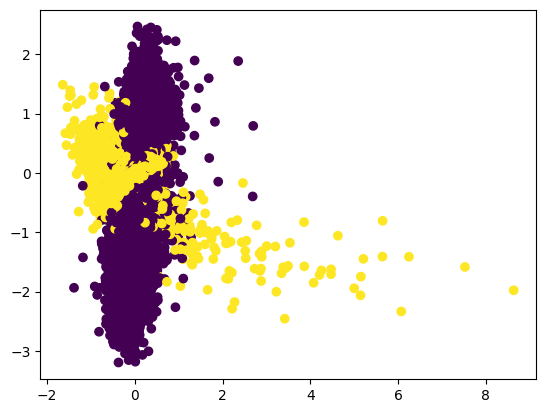

In [87]:
preds = pred(train_ldr, model,DEVICE).to_numpy()
diff = preds - train_ds.tensors[1].numpy()
plt.scatter(diff[:,0], diff[:,1], c=train_ds.tensors[0][:, -1])

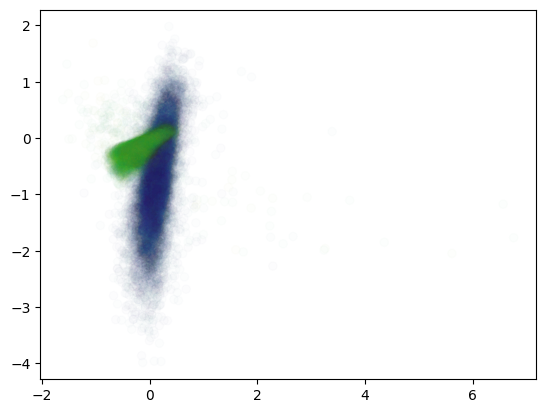

In [78]:
preds = pred(test_ldr, model,DEVICE).to_numpy()
diff = preds - test_ds.tensors[1].numpy()
plt.scatter(diff[:,0], diff[:,1], c=test_ds.tensors[0][:, 8], alpha=0.01)

In [ ]:
for n in model.parameters():
    print(n)

Parameter containing:
tensor([[ 0.0118, -0.0312,  0.2727,  ..., -0.1000,  0.1114, -0.1255],
        [ 0.1641, -0.1245, -0.2137,  ...,  0.0217, -0.0787, -0.0840],
        [ 0.0458,  0.1109,  0.0730,  ...,  0.0505, -0.1816,  0.0823],
        ...,
        [-0.0734,  0.1439,  0.0265,  ...,  0.1055, -0.0239, -0.1748],
        [-0.0438,  0.1150, -0.0665,  ..., -0.1448,  0.0229,  0.0387],
        [ 0.0296, -0.1027,  0.2233,  ...,  0.3145,  0.0071, -0.0243]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.1404, -0.0054, -0.0605, -0.0089,  0.0495,  0.1008,  0.1719,  0.1290,
        -0.0496, -0.1861, -0.0818,  0.2091, -0.1902,  0.1778,  0.0457,  0.1111,
        -0.0277,  0.0575, -0.1139,  0.1550, -0.0159,  0.0342,  0.0747,  0.2324,
         0.1258,  0.0042,  0.0290, -0.0141,  0.1272,  0.0590,  0.1597,  0.1868,
         0.1035,  0.1525, -0.1674, -0.0443,  0.0198,  0.0395,  0.0809, -0.1841,
        -0.1614,  0.0057,  0.1775, -0.0765, -0.2238, -0.1503,  0.1753,  0.0292